Demo #6: Parameters tuning  \
- For model 
- For SKF (Switching Kalman Filter)

Import libraries

In [49]:
from pathlib import Path
project_root = Path.cwd().resolve().parents[1]
import ray 
ray.shutdown() 
ray.init(runtime_env={"working_dir": project_root})
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric
import copy

2025-04-28 11:44:54,690	INFO worker.py:1852 -- Started a local Ray instance.
2025-04-28 11:44:56,021	INFO packaging.py:575 -- Creating a file package for local module '/Users/vuongdai/GitHub/canari'.
2025-04-28 11:44:56,035	WARNING packaging.py:417 -- File /Users/vuongdai/GitHub/canari/.git/objects/92/45ee127ddd1bf42655a9cbd1f0de336db6289d is very large (10.22MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/Users/vuongdai/GitHub/canari/.git/objects/92/45ee127ddd1bf42655a9cbd1f0de336db6289d']})`
2025-04-28 11:44:56,058	WARNING packaging.py:417 -- File /Users/vuongdai/GitHub/canari/.git/objects/57/117f0488cb76d05e1639784f731008c7d9828d is very large (12.33MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/Users/vuongdai/GitHub/canari/.git/objects/57/117f0488cb76d05e1639784f731008c7d9828d']})`
2025-04-28 11:44:56,079	WARNING packaging.py:417 -- File /

Import components

In [50]:
from canari import (
    DataProcess,
    Model,
    SKF,
    ModelOptimizer,
    SKFOptimizer,
    plot_data,
    plot_prediction,
    plot_states,
    plot_skf_states,
)
from canari.component import LocalTrend, LocalAcceleration ,LstmNetwork, WhiteNoise

Read data

In [51]:
data_file = str(project_root / "data" / "benchmark_data" / "test_4_data.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, 1:]
df.index = time
df.index.name = "time"
df.columns = ["crack opening", "water_level", "temp_min", "temp_max"]
lags = [0, 4, 4, 4]
df_lag = DataProcess.add_lagged_columns(df, lags)

Data preprocess

In [52]:
output_col = [0]
data_processor = DataProcess(
    data=df_lag,
    time_covariates=["week_of_year"],
    train_split=0.23,
    validation_split=0.07,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
(
    data_processor.train_data,
    data_processor.validation_data,
    data_processor.test_data,
    data_processor.all_data,
) = data_processor.get_splits()

Step #1: Tune parameters for model

1A. Define model with parameters

In [53]:
def initialize_model(param):
    return Model(
        LocalTrend(),
        LstmNetwork(
            look_back_len=param["look_back_len"],
            num_features=17,
            num_layer=1,
            num_hidden_unit=50,
            device="cpu",
            manual_seed=1,
        ),
        WhiteNoise(std_error=param["sigma_v"]),
    )

1B. Parameter search space

In [54]:
param = {
    "look_back_len": [12, 65],
    "sigma_v": [1e-3, 2e-1],
}

1C. Training procedure

In [ ]:
def training(model, data_processor, num_epoch: int = 50):
    """
    Training procedure
    """

    model.auto_initialize_baseline_states(data_processor.train_data["y"][0 : 52 * 3])
    states_optim = None
    mu_validation_preds_optim = None
    std_validation_preds_optim = None

    for epoch in range(num_epoch):
        mu_validation_preds, std_validation_preds, states = model.lstm_train(
            train_data=data_processor.train_data,
            validation_data=data_processor.validation_data,
        )

        mu_validation_preds_unnorm = Normalizer.unstandardize(
            mu_validation_preds,
            data_processor.std_const_mean[data_processor.output_col],
            data_processor.std_const_std[data_processor.output_col],
        )

        std_validation_preds_unnorm = Normalizer.unstandardize_std(
            std_validation_preds,
            data_processor.std_const_std[data_processor.output_col],
        )

        validation_obs = data_processor.get_data("validation").flatten()
        validation_log_lik = metric.log_likelihood(
            prediction=mu_validation_preds_unnorm,
            observation=validation_obs,
            std=std_validation_preds_unnorm,
        )

        model.early_stopping(evaluate_metric=-validation_log_lik, current_epoch=epoch, max_epoch=num_epoch)

        if epoch == model.optimal_epoch:
            mu_validation_preds_optim = mu_validation_preds.copy()
            std_validation_preds_optim = std_validation_preds.copy()
            states_optim = copy.copy(states)
        
        model.set_memory(states=states, time_step=0)
        if model.stop_training:
            break

    return (
        model,
        states_optim,
        mu_validation_preds_optim,
        std_validation_preds_optim,
    )

1. Model optimizer

In [56]:
model_optimizer = ModelOptimizer(
    initialize_model=initialize_model,
    train=training,
    param_space=param,
    data_processor=data_processor,
    num_optimization_trial=50,
)
model_optimizer.optimize()
# Get optimal model
model_optim = model_optimizer.get_best_model()

#  1/50 - Metric: -0.754 - Parameter: {'look_back_len': 35, 'sigma_v': 0.07666312499119976}
#  2/50 - Metric: -0.139 - Parameter: {'look_back_len': 21, 'sigma_v': 0.17843369272267542}
#  3/50 - Metric: -0.551 - Parameter: {'look_back_len': 24, 'sigma_v': 0.16799861634042695}
#  4/50 - Metric: -1.088 - Parameter: {'look_back_len': 26, 'sigma_v': 0.036376768548118554}


2025-04-28 11:45:20,825	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-04-28 11:45:20,831	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/Model_optimizer' in 0.0060s.
2025-04-28 11:45:21,817	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2025-04-28 11:45:22,145	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- objective_9636fa95: FileNotFoundError('Could not fetch metrics for objective_9636fa95: both result.json and progress.csv were not found at /Users/vuongdai/ray_results/Model_optimizer/objective_9636fa95_7_look_back_len=33,sigma_v=0.1761_2025-04-28_11-45-20')


-----
Optimal parameters at trial #4: {'look_back_len': 26, 'sigma_v': 0.036376768548118554}
-----


Train the optimal model again

In [41]:
model_optim, states_optim, mu_validation_preds, std_validation_preds = training(
    model=model_optim, data_processor=data_processor
)

Save optimal model for SKF analysis later

In [42]:
model_optim_dict = model_optim.get_dict()

Step #2: Tune parameters for SKF

2A. Define SKF model with parameters

In [43]:
def initialize_skf(skf_param, model_param: dict):
    norm_model = Model.load_dict(model_param)
    abnorm_model = Model(
        LocalAcceleration(),
        LstmNetwork(),
        WhiteNoise(),
    )
    skf = SKF(
        norm_model=norm_model,
        abnorm_model=abnorm_model,
        std_transition_error=skf_param["std_transition_error"],
        norm_to_abnorm_prob=skf_param["norm_to_abnorm_prob"],
        abnorm_to_norm_prob=1e-1,
        norm_model_prior_prob=0.99,
    )
    return skf

2B. Parameters space

In [44]:
slope_upper_bound = 5e-2
slope_lower_bound = 1e-3
grid_search = False
if grid_search:
    skf_param = {
        "std_transition_error": [1e-6, 1e-5, 1e-4, 1e-3],
        "norm_to_abnorm_prob": [1e-6, 1e-5, 1e-4, 1e-3],
        "slope": [0.002, 0.004, 0.006, 0.008, 0.01, 0.03, 0.05, 0.07, 0.09],
    }
else:
    skf_param = {
        "std_transition_error": [1e-6, 1e-3],
        "norm_to_abnorm_prob": [1e-6, 1e-3],
        "slope": [slope_lower_bound, slope_upper_bound],
    }

Detect synthetic anomalies

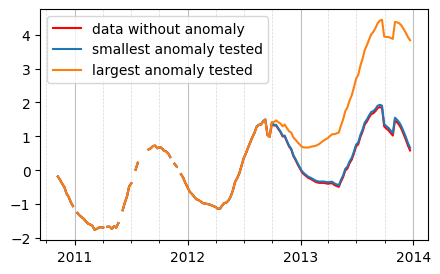

In [45]:
synthetic_anomaly_data = DataProcess.add_synthetic_anomaly(
    data_processor.train_data,
    num_samples=1,
    slope=[slope_lower_bound, slope_upper_bound],
)
fig, ax = plt.subplots(figsize=(5,3))
plot_data(
    data_processor=data_processor,
    standardization=True,
    plot_validation_data=False,
    plot_test_data=False,
    plot_column=output_col,
    train_label="data without anomaly",
)

train_time = data_processor.get_time("train")
for ts in synthetic_anomaly_data:
    plt.plot(train_time, ts["y"])
plt.legend(
    [
        "data without anomaly",
        # "",
        "smallest anomaly tested",
        "largest anomaly tested",
    ]
)

2. SKF optimizer

In [46]:
skf_optimizer = SKFOptimizer(
    initialize_skf=initialize_skf,
    model_param=model_optim_dict,
    param_space=skf_param,
    data=data_processor.train_data,
    num_synthetic_anomaly=50,
    num_optimization_trial=100,
    grid_search=grid_search,
)
skf_optimizer.optimize()
# Get optimal model
skf_optim = skf_optimizer.get_best_model()

#   1/100 - Metric: 2.014 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.00038952700617852197, 'norm_to_abnorm_prob': 1.8650868439747936e-06, 'slope': 0.0028000953116403696}
#   2/100 - Metric: 2.051 - Detection rate: 0.34 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 7.34677623338615e-06, 'norm_to_abnorm_prob': 0.0004303207096571881, 'slope': 0.010260818831360012}
#   3/100 - Metric: 2.009 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.0002506445442949936, 'norm_to_abnorm_prob': 1.5989546529182403e-05, 'slope': 0.001715652475016509}
#   4/100 - Metric: 2.009 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 2.0911588848777468e-05, 'norm_to_abnorm_prob': 0.0003169587781564642, 'slope': 0.0018609242879148173}
#   5/100 - Metric: 0.768 - Detection rate: 0.72 - False rate: 

2025-04-28 10:29:36,896	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/SKF_optimizer' in 0.0208s.


# 100/100 - Metric: 0.817 - Detection rate: 0.80 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.0007255271841827302, 'norm_to_abnorm_prob': 5.800366725751609e-06, 'slope': 0.0034244834365172463}
-----
Optimal parameters at trial #22: {'std_transition_error': 0.0007362128367577096, 'norm_to_abnorm_prob': 6.1791791272095545e-06, 'slope': 0.0010137198483750908}
-----


Anomaly detection

In [47]:
filter_marginal_abnorm_prob, states = skf_optim.filter(data=data_processor.all_data)
smooth_marginal_abnorm_prob, states = skf_optim.smoother(
    data=data_processor.all_data
)

Plot results

Text(0.5, 1, 'SKF hidden states')

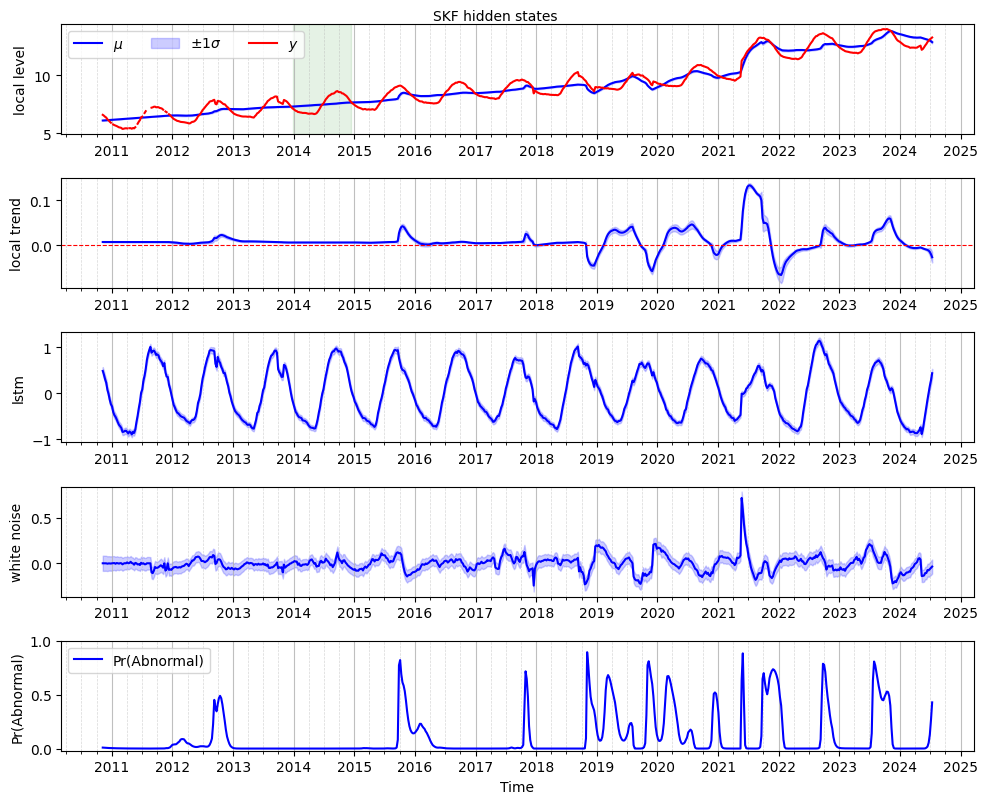

In [ ]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    states_to_plot=["level", "trend", "lstm", "white noise"],
    model_prob=filter_marginal_abnorm_prob,
    color="b",
    legend_location="upper left",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)